Neste Mini-Projeto vamos apresentar um guia básico de análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Usaremos dados reais disponíveis publicamente, dados sobre filmes no IMDB.

Guias avançados de Análise Exploratória de Dados são fornecidos na Formação Cientista de Dados.

Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

2- Qual o Número de Títulos Por Gênero?

3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

7- Qual a Relação Entre Duração e Gênero?

8- Qual o Número de Filmes Produzidos Por País?

9- Quais São os Top 10 Melhores Filmes?

10- Quais São os Top 10 Piores Filmes?

Instalando e Carregando Pacotes

In [1]:
#Verificando a versão do Python
from platform import python_version
print('Versão Python:', python_version())

Versão Python: 3.8.8


In [2]:
#Instalando pacotes
!pip install -q imdb-sqlite

In [3]:
!pip install -q pycountry

In [4]:
#Importando pacotes
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

Carregando os Dados

In [5]:
%%time
!imdb-sqlite

Wall time: 867 ms


2022-01-13 09:02:19,364 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
#Conectando no banco
conn = sqlite3.connect("imdb.db")

In [7]:
#Extrai a lista de tabelas
tabelas = pd.read_sql_query("select name as 'Table_Name' from sqlite_master where type = 'table'", conn)

In [8]:
#Verifica o tipo de objeto de tabelas
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
#Visualiza o resultado da query
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
#Convertendo o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [11]:
#Percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Analise Exploratória dos Dados

1 - Quais são as categorias de filmes mais comuns no IMBD?

In [12]:
#Criando a consulta SQL
consulta1 = '''select type, count(*) as count from titles group by type '''

In [13]:
#Extraindo o resultado da consulta1
resultado1 = pd.read_sql_query(consulta1, conn)

In [14]:
#Visualizando o resultado da consulta1
display(resultado1)

,type,count
0,movie,598757
1,short,850453
2,tvEpisode,6418895
3,tvMiniSeries,41500
4,tvMovie,134477
5,tvPilot,2
6,tvSeries,219146
7,tvShort,10434
8,tvSpecial,35576
9,video,256472


In [15]:
#Calculando um percentual para cada tipo
resultado1['percentual'] = (resultado1['count'] / resultado1['count'].sum()) * 100

In [16]:
#Visualizando o resultado do percentual
display(resultado1)

,type,count,percentual
0,movie,598757,6.965647
1,short,850453,9.893756
2,tvEpisode,6418895,74.674297
3,tvMiniSeries,41500,0.482791
4,tvMovie,134477,1.564440
5,tvPilot,2,0.000023
6,tvSeries,219146,2.549438
7,tvShort,10434,0.121384
8,tvSpecial,35576,0.413874
9,video,256472,2.983670


In [17]:
#Criando gráfico com apenas 4 categorias:
#As 3 categorias com mais titulos e 1 categoria com todo o restante

#Criando um dicionario vazia
others = {}

#Filtra o percentual em 5% e soma o total
others['count'] = resultado1[resultado1['percentual'] < 5]['count'].sum()

#Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

#Ajustando o nome
others['type'] = 'others'

In [18]:
#Visualizando
others

{'count': 727751, 'percentual': 8.466300505732065, 'type': 'others'}

In [19]:
#Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual']>5]

In [20]:
#Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index=True)

In [21]:
#Ordenando o resultado
resultado1 = resultado1.sort_values(by = 'count', ascending = False)

In [22]:
#visualizando o resultado
resultado1.head()

,type,count,percentual
2,tvEpisode,6418895,74.674297
1,short,850453,9.893756
3,others,727751,8.466301
0,movie,598757,6.965647


In [23]:
#Ajustando os labels
labels = [str(resultado1['type'][i])+ ' ' +'['+str(round(resultado1['percentual'][i],2)) + '%'+']' for i in resultado1.index]

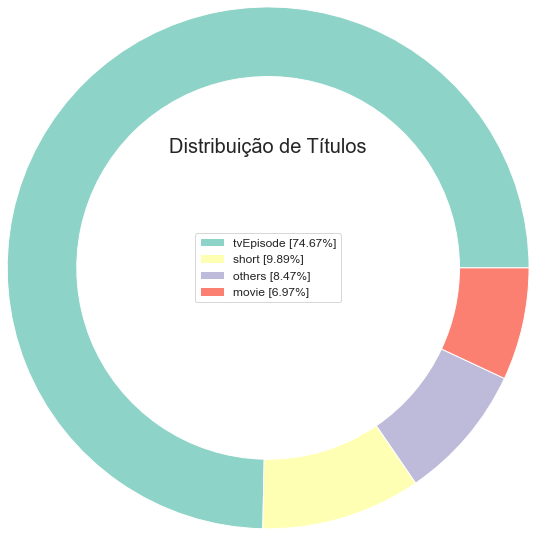

In [24]:
#Montando o grafico
#Plot

#Mapa de cores
cs = cm.Set3(np.arange(100))

#Cria a figura
f = plt.figure()

#Pie Plot
plt.pie(resultado1['count'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size' : 12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show()

2 - Qual o número de títulos por gênero?

In [25]:
#Criando a consulta SQL
consulta2 = '''select genres, count(*) from titles where type = 'movie' group by genres'''

In [26]:
#Resultado da consulta2
resultado2 = pd.read_sql_query(consulta2, conn)

In [27]:
#Visualizando o resultado
display(resultado2)

,genres,count(*)
0,Action,13740
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1449,"Thriller,Western",43
1450,War,1282
1451,"War,Western",13
1452,Western,5104


In [28]:
#Convertendo as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [29]:
#Removendo os valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [30]:
#Criando um vetor usando expressão regular para filtras as strings
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [31]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [32]:
#Aplicando a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [33]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [34]:
#Retornando generos unicos
generos_unicos = vetor.get_feature_names()

In [35]:
#Criando o dataframe de generos
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [36]:
#Visualizando
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1453
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1454 non-null   int64
 1   adult        1454 non-null   int64
 2   adventure    1454 non-null   int64
 3   animation    1454 non-null   int64
 4   biography    1454 non-null   int64
 5   comedy       1454 non-null   int64
 6   crime        1454 non-null   int64
 7   documentary  1454 non-null   int64
 8   drama        1454 non-null   int64
 9   family       1454 non-null   int64
 10  fantasy      1454 non-null   int64
 11  film-noir    1454 non-null   int64
 12  game-show    1454 non-null   int64
 13  history      1454 non-null   int64
 14  horror       1454 non-null   int64
 15  music        1454 non-null   int64
 16  musical      1454 non-null   int64
 17  mystery      1454 non-null   int64
 18  n            1454 non-null   int64
 19  news         1454 non-null   int64
 20  reality-

In [37]:
#Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [38]:
#Calculando o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
#Visualizando
generos_percentual.head(10)

drama          18.225585
comedy         16.918845
documentary    15.955983
adventure      14.924347
action         14.374140
romance        13.342503
crime          13.067400
mystery        12.448418
fantasy        12.242091
thriller       12.242091
dtype: float64

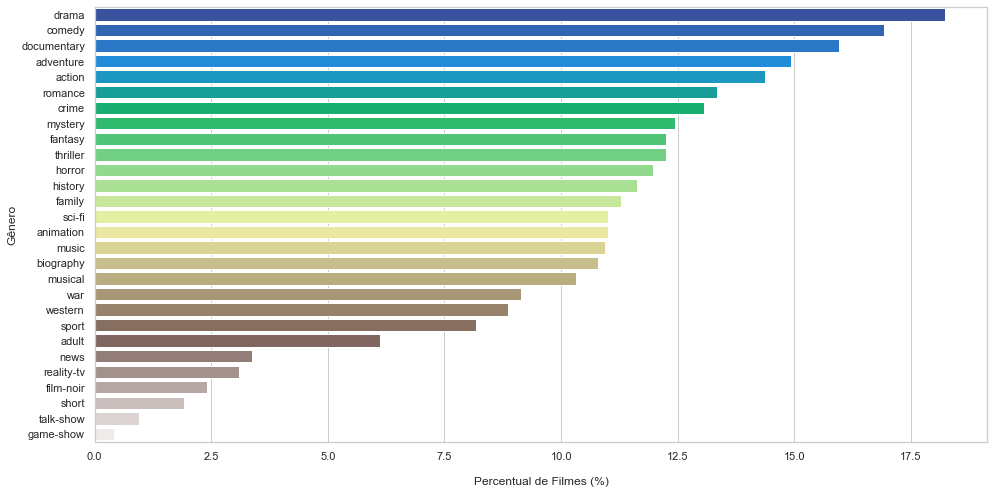

In [40]:
#Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.show()

3 - Qual a mediana de Avaliação dos Filmes por Gênero?

In [41]:
#Criando a consulta SQL
consulta3 = '''select rating, genres from
               ratings join titles on ratings.title_id = titles.title_id
               where premiered <= 2022 and type = 'movie'
               '''

In [42]:
#Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
#Visualizando
display(resultado3)

,rating,genres
0,4.4,\N
1,6.1,"Action,Adventure,Biography"
2,5.0,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
273452,3.5,"Action,Adventure,Thriller"
273453,5.8,Thriller
273454,6.4,"Drama,History"
273455,3.8,"Adventure,History,War"


In [44]:
#Criando função para retornar os generos
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [45]:
#Aplicando a função
generos_unicos = retorna_generos(resultado3)

In [46]:
#Visualizando
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [49]:
#Criando lista vazias
genero_counts = []
genero_ratings = []

In [50]:
#Loop
for item in generos_unicos:
    #Retorna a contagem de filmes por gênero
    consulta = 'Select count(rating) from ratings join titles on ratings.title_id = titles.title_id where genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    #Retorna a avaliação de filmes por gênero
    consulta = 'select rating from ratings join titles on ratings.title_id = titles.title_id where genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [51]:
#Preparando o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [52]:
#visualidando o dataframe
df_genero_ratings.head(20)

,genres,count,rating
0,action,28336,5.8
1,adult,4231,5.9
2,adventure,17196,6.0
3,animation,4812,6.4
4,biography,8242,7.0
5,comedy,67790,6.0
6,crime,23352,6.1
7,documentary,40437,7.3
8,drama,121151,6.3
9,family,10608,6.3


In [53]:
#Não queremos o genero news, então vamos remover do df com drop no indice(18)
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [54]:
#Ordenando o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

In [55]:
#Visualizando
df_genero_ratings.head(20)

,genres,count,rating
7,documentary,40437,7.3
22,short,24,7.2
4,biography,8242,7.0
13,history,7520,6.9
24,talk-show,8,6.9
12,game-show,2,6.8
23,sport,3235,6.7
11,film-noir,761,6.6
26,war,5880,6.6
15,music,12417,6.6


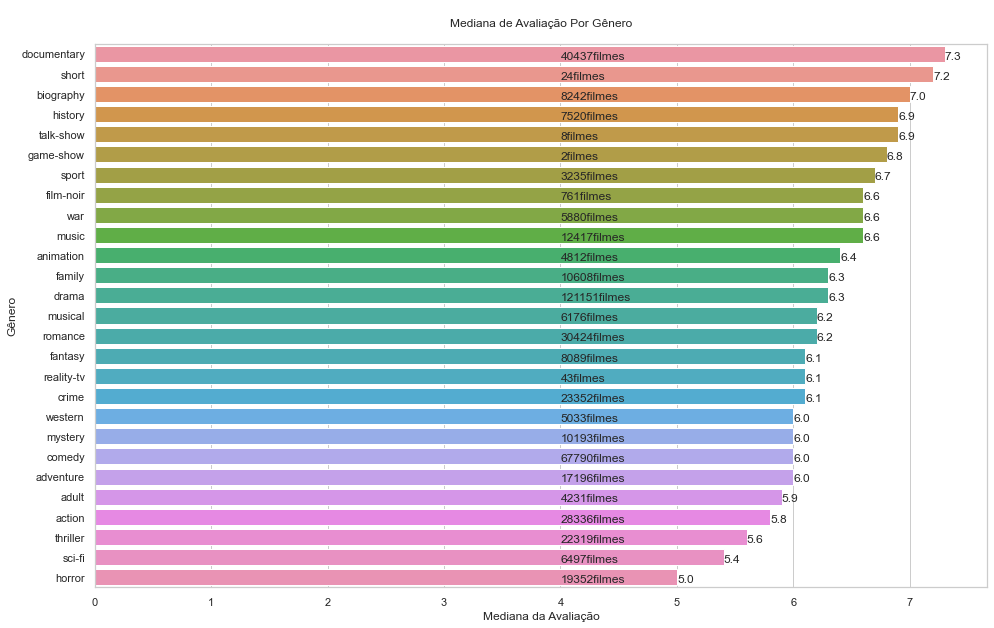

In [61]:
#Criando o gráfico

#Figura
plt.figure(figsize = (16,10))

#Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

#Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    plt.text(4.0, 
            i + 0.25,
            str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + "filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
            i + 0.25,
            round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))
    
plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

4 - Qual a mediana de avaliação dos filmes em relação ao ano de estréia?

In [62]:
#Criando a consulta SQL
consulta4 = '''
            select rating as Rating, premiered from
            ratings join titles on ratings.title_id = titles.title_id
            where premiered <= 2022 and type = 'movie'
            order by premiered
            '''

In [63]:
#Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [64]:
#Visualizando o resultado
display(resultado4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
273452,7.9,2022
273453,8.8,2022
273454,4.8,2022
273455,1.2,2022


In [65]:
#Calculando a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [66]:
type(ratings)

list

In [67]:
#Visualizando dados da lista de avaliações criada
ratings[1:10]

[4.5, 3.8, 5.85, 4.6, 3.5, 5.6, 5.4, 4.4, 3.6]

In [68]:
#Criando a lista de anos
anos = list(set(resultado4['premiered']))

In [69]:
#Visualizando dados da lista de ano criada
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

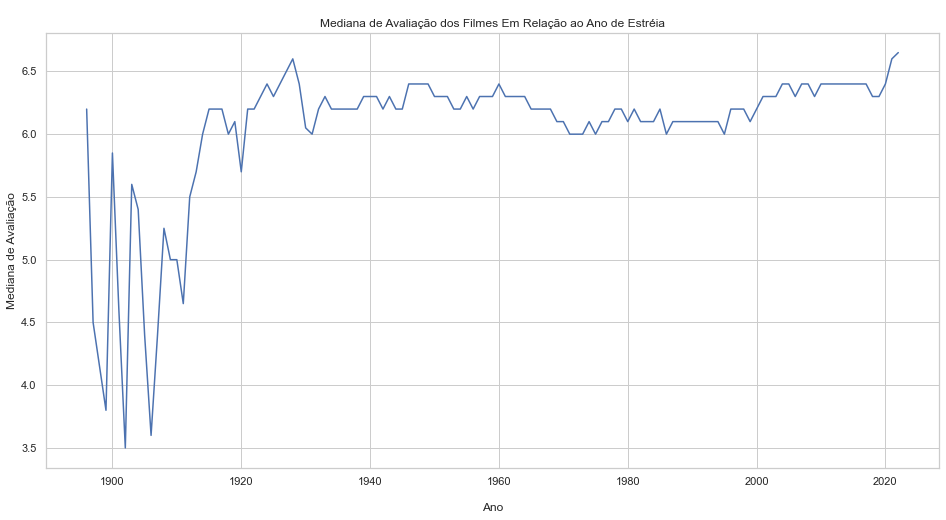

In [70]:
#Criando o gráfico

#Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia')
plt.show()

5 - Qual o número de filmes avaliados por gênero em relação ao ano de estréia?

In [71]:
#Criando a consulta SQL
consulta5 = ''' select genres from titles'''

In [72]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [73]:
#Visualizando o resultado
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8595851,"Action,Drama,Family"
8595852,"Action,Drama,Family"
8595853,"Action,Drama,Family"
8595854,Short


In [74]:
#Pegando os generos unicos
generos_unicos = retorna_generos(resultado5)

In [76]:
#Fazendo a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'select count(*) count from titles where genres like'+ '\''+'%'+item+'%'+'\' and type=\'movie\' and premiered <= 2022' 
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['count'].values[0])

In [77]:
#Preparando o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['count'] = genero_count


In [78]:
#Calculando os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

In [82]:
top_generos

array(['drama', 'documentary', 'comedy', 'action', 'romance'],
      dtype=object)

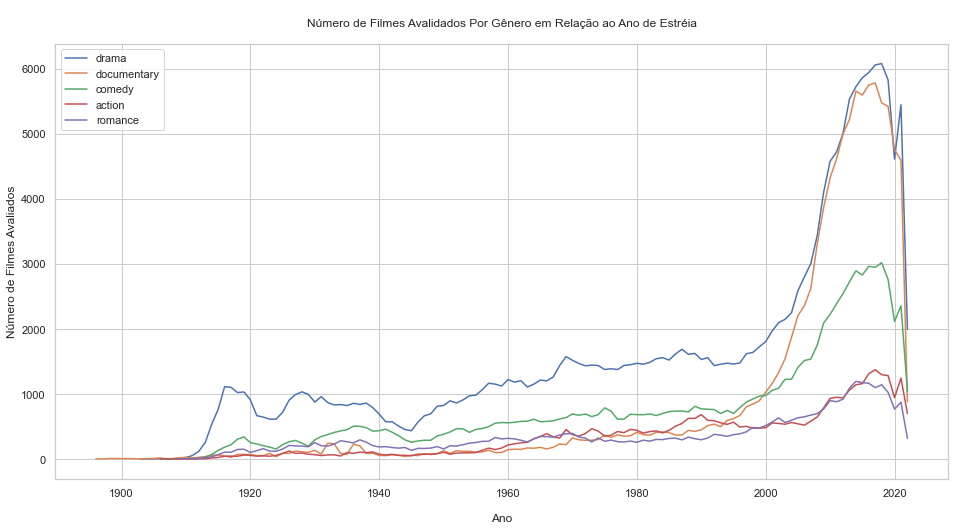

In [84]:
#Criando o gráfico

#Figura
plt.figure(figsize = (16,8))

#Loop e Plot
for item in top_generos:
    consulta = 'select count(*) number_of_movies, premiered Year from titles where genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['number_of_movies'])
    
plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avalidados Por Gênero em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

9 - Qual o filme com o maior tempo de duração? Calcule os percentis

In [90]:
#Criando a consulta SQL
consulta6 = '''
            select runtime_minutes Runtime
            from titles
            where type = 'movie' and Runtime != 'NaN'
            '''

In [91]:
#resultado
resultado6 = pd.read_sql_query(consulta6,conn)

In [92]:
#Visualizando o resultado
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
376570,123
376571,57
376572,100
376573,116


In [93]:
#Loop para cálculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val),2)
    print('{} percentil da duração (runtime) é: {}'.format(val,perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [97]:
#Refazendo a consulta retornando o fime com maior duração
consulta6 = '''
            select runtime_minutes Runtime, primary_title
            from titles
            where type = 'movie' and Runtime != 'NaN'
            order by Runtime desc
            limit 1
            '''

In [98]:
#resultado
resultado6 = pd.read_sql_query(consulta6,conn)

In [99]:
resultado6

,Runtime,primary_title
0,51420,Logistics


In [100]:
#Validando se esse outlier é um erro pesquisando o filme
# Logstics é um filme experimental sueco de 2012 concebido e criado por Erika Magnusson e Daniel Andersson. 
#Com 51.420 minutos, é o filme mais longo já feito.
#Realmente o filme tem essa duração mesmo e não se trata de um erro.

7 - Qual a relação entre duração e gênero?

In [103]:
#Criando a consulta SQL
consulta7 = '''
            select avg(runtime_minutes) Runtime, genres
            from titles
            where type = 'movie'
            and runtime_minutes != 'NaN'
            group by genres
            '''

In [104]:
#resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [105]:
#Visualizando resultado
display(resultado7)

,Runtime,genres
0,99.263136,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1364,94.625000,"Thriller,Western"
1365,94.111296,War
1366,93.636364,"War,Western"
1367,70.702212,Western


In [106]:
#Retornando generos unicos
generos_unicos = retorna_generos(resultado7)

In [107]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [111]:
#Calculando a duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'select runtime_minutes Runtime from titles where genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [115]:
#Preparando o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [116]:
df_genero_runtime

,genre,runtime
0,action,94.0
1,adult,77.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [118]:
#Não queremos genero news, então removemos do dataframe
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [119]:
#ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

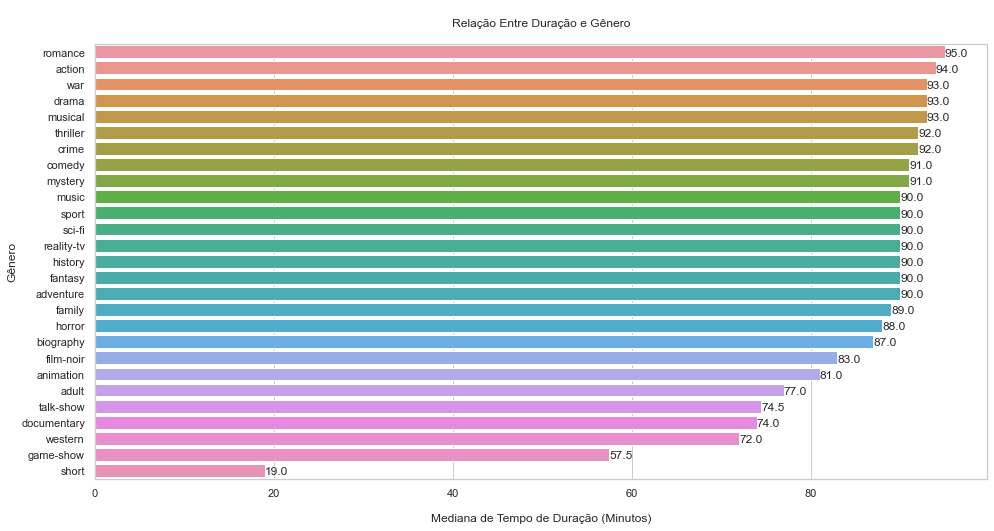

In [122]:
#Criando o gráfico

#Figura
plt.figure(figsize = (16,8))

#Barplot
sns.barplot(y= df_genero_runtime.genre, x= df_genero_runtime.runtime, orient = "h")

#Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
            i + 0.25,
            round(df_genero_runtime['runtime'][df_genero_runtime.index[i]],2))
    
plt.ylabel('Gênero')
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

8 - Qual o número de filmes produzidos por país?

In [126]:
#Criando a consulta SQL
consulta8 = '''
            select region, count(*) number_of_movies from
            akas join titles on
            akas.title_id = titles.title_id
            where region != 'None'
            and type = \'movie\'
            group by region
            '''

In [127]:
#Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [128]:
resultado8

,region,number_of_movies
0,AD,22
1,AE,4275
2,AF,109
3,AG,12
4,AL,1253
...,...,...
229,YUCS,150
230,ZA,3122
231,ZM,12
232,ZRCD,2


In [129]:
#shape
resultado8.shape

(234, 2)

In [130]:
#Listas auxiliares para numero de paises e contagem
nomes_paises = []
contagem = []

In [131]:
#loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['number_of_movies'].values[i])
    except:
        continue          

In [133]:
nomes_paises[1:10]

['United Arab Emirates',
 'Afghanistan',
 'Antigua and Barbuda',
 'Albania',
 'Armenia',
 'Angola',
 'Antarctica',
 'Argentina',
 'American Samoa']

In [134]:
contagem[1:10]

[4275, 109, 12, 1253, 305, 52, 3, 29482, 2]

In [135]:
#preparando o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['movie_count'] = contagem

In [136]:
df_filmes_paises

,country,movie_count
0,Andorra,22
1,United Arab Emirates,4275
2,Afghanistan,109
3,Antigua and Barbuda,12
4,Albania,1253
...,...,...
208,Samoa,1
209,Yemen,11
210,South Africa,3122
211,Zambia,12


In [137]:
#Ordenando o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'movie_count', ascending = False)

In [138]:
df_filmes_paises.head(10)

,country,movie_count
199,United States,304951
65,United Kingdom,156848
96,Japan,90000
63,France,83350
89,India,78029
32,Canada,74677
47,Germany,69057
93,Italy,64660
58,Spain,64268
26,Brazil,64161


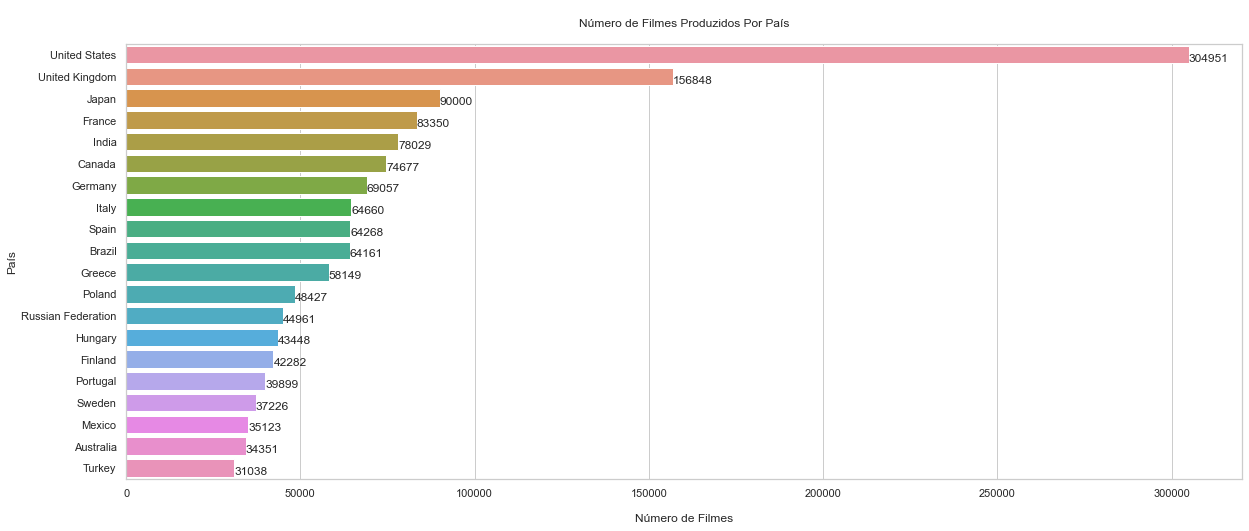

In [141]:
#Criando o gráfico

#figura
plt.figure(figsize = (20,8))

#Barplot
sns.barplot(y= df_filmes_paises[:20].country, x= df_filmes_paises[:20].movie_count, orient = "h")

#Loop
for i in range(0,20):
    plt.text(df_filmes_paises.movie_count[df_filmes_paises.index[i]] -1,
            i + 0.30,
            round(df_filmes_paises['movie_count'][df_filmes_paises.index[i]],2))
    
plt.ylabel('País')
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

9 - Quais são sos top 10 melhores filmes

In [148]:
#Criando consulta SQL
consulta9 = '''
            select primary_title as movie_name, genres, rating from
            titles join ratings on titles.title_id = ratings.title_id
            where titles.type = 'movie' and ratings.votes>=25000
            order by rating desc
            limit 10
            '''

In [149]:
#Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [150]:
#Visualizando o resultado
display(top10_melhores_filmes)

,movie_name,genres,rating
0,Jai Bhim,"Crime,Drama",9.4
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Mirror Game,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


10 - Quais são sos top 10 piores filmes

In [151]:
#Criando consulta SQL
consulta10 = '''
            select primary_title as movie_name, genres, rating from
            titles join ratings on titles.title_id = ratings.title_id
            where titles.type = 'movie' and ratings.votes>=25000
            order by rating asc
            limit 10
            '''

In [152]:
#Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [153]:
#Visualizando o resultado
display(top10_piores_filmes)

,movie_name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,The Cost of Deception,"Crime,Drama,History",1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,Horror,1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Radhe,"Action,Crime,Thriller",1.9


Fim